# Basics methods for training and prediction using Keras

In [1]:
from IPython.display import display, Markdown
with open('../../doc/env_variables_setup.md', 'r') as fh:
    content = fh.read()
display(Markdown(content))

Environment variables that need to be defined:   
`export DIR_PROJ=your_path_git_repository`  
`export PYTHONPATH=$DIR_PROJ/src`  
`export PATH_TENSORBOARD=your_path_tensorboard`  
`export PATH_DATASETS=your_path_datasets`  
`export PROJECT_ID=your_gcp_project_id`  
`export BUCKET_NAME=your_gcp_gs_bucket_name`  
`export REGION=your_region`  
`export MODEL_DIR_ESTIMATOR_PATH=your_path_to_save_model` 

- Use local Jupyter Lab 
    - you need to have the `jupyter-notebook` Anaconda python environment created [link](local_jupyter_lab_installation.md) 
    - you need to have the `jupyter-notebook` Anaconda python environment activated [link](local_jupyter_lab_installation.md) 
    - then define the environment variables above (copy and paste) 
    - you need to have the `env_multilingual_class` Anaconda python environment created [link](local_jupyter_lab_installation.md)  
    - start Jupyter Lab:  `jupyter lab` 
    - open a Jupyter Lab notebook from `notebook/` 
     - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - choose the proper Anaconda python environment:  `Python [conda env:env_multilingual_class]` [link](conda_env.md) 
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`


- Use GCP Jupyter Lab 
    - Go on GCP
    - open a Cloud Shell
    - `ssh-keygen -t rsa -b 4096 -C firstName_lastName`
    - `cp .ssh/id_rsa.pub .`
    - use Cloud Editor to edit this file `id_rsa.pub` and copy the full content
    - Go on Compute Engine -> Metadata
    - Click SSH Keys
    - Click Edit
    - Click + Add item, copy the content of `id_rsa.pub`
    - You should see firstName_lastName of the left
    - Click Save
    - you need to start a AI Platform instance 
    - open a Jupyter Lab terminal and got to `/home/gcp_user_name/`
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - then `cd proj_multilingual_text_classification/`
    - create the Anacond Python environment `conda env create -f env/environment.yml`
    - create a file `config.sh` in `/home` with the following information: 
    ```
    #!/bin/bash
    
    echo "applying some configuration ..."
    git config --global user.email user_email
    git config --global user.name user_name
    git config --global credential.helper store
        
    # Add here the enviroment variables from above below
    # [EDIT ME]
    export DIR_PROJ=your_path_git_repository
    export PYTHONPATH=$DIR_PROJ/src
  
    cd /home/gcp_user_name/
    
    conda activate env_multilingual_class

    export PS1='\[\e[91m\]\u@:\[\e[32m\]\w\[\e[0m\]$'
    ```
    - Got to AI Platform Notebook, select your instance and click "Reset".
    - Wait and reshreh you Web browser with the Notebook


## Import packages

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from absl import logging
import matplotlib.pyplot as plt
import os
import datetime
import numpy
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [3]:
%load_ext tensorboard

## Define paths

In [4]:
try:
    data_dir=os.environ['PATH_DATASETS']
except:
    print('missing PATH_DATASETS')

In [5]:
print(data_dir)

/Users/tarrade/tensorflow_datasets


## Import local packages

In [6]:
import utils.model_metrics  as model_metrics

In [7]:
import importlib
importlib.reload(model_metrics);

## Getting and preprocessing data

In [8]:
# Setup logging verbosity
logging.set_verbosity(logging.INFO)

# Define the model's hyperparameters
STEPS_PER_EPOCH = 6
#BUFFER_SIZE = 10 # Use a much larger value for real code. 
#BATCH_SIZE = 64
BUFFER_SIZE = 10000
BATCH_SIZE = 500
NUM_EPOCHS = 25

In [9]:
def input_fn():
    import tensorflow as tf
    datasets, ds_info = tfds.load(name='mnist', with_info=True, as_supervised=True, data_dir=data_dir)
    mnist_train, mnist_test = datasets['train'], datasets['test']



    def scale(image, label):
        image = tf.cast(image, tf.float32)
#        image = tf.dtypes.cast(image, tf.float32)
        image /= 255
    
        return image, label

    #train_data = mnist_train.map(scale).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    #test_data = mnist_test.map(scale).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    train_data = mnist_train.repeat().map(scale).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    test_data = mnist_test.repeat().map(scale).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    return train_data, test_data

In [10]:
train_data, test_data = input_fn()

INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Field info.location from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/Users/tarrade/tensorflow_datasets/mnist/3.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /Users/tarrade/tensorflow_datasets/mnist/3.0.0


In [11]:
# experimenting with keras inputs by combining training and test data
data = train_data.concatenate(test_data)
# abandoning this idea because:
#The argument validation_split (generating a holdout set from the training data) is not supported when 
#training from Dataset objects, since this features requires the ability to index the samples of the datasets, 
#which is not possible in general with the Dataset API.

In [12]:
#tf.data.experimental.cardinality(train_data)


In [13]:
#for l in test_data:
#    print(l[0].numpy()[0].shape)
#    break

## Build the model

In [14]:
def make_model():
    import tensorflow as tf
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu',
                               kernel_regularizer=tf.keras.regularizers.l2(0.02),
                               input_shape=(28, 28, 1)),
        
        # play around from here on...
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        # ... until here
        tf.keras.layers.Dense(10, activation='softmax')
    ])

In [15]:
def make_model2():
    import tensorflow as tf
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu',
                               kernel_regularizer=tf.keras.regularizers.l2(0.02),
                               input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(128, activation='relu'),        
        tf.keras.layers.BatchNormalization(),

        # ... until here
        tf.keras.layers.Dense(10, activation='softmax')
    ])

In [16]:
model = make_model2()

In [17]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              #loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               692352    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

## Training the model

In [19]:
# implement tensorboard
import tensorflow as tf
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [20]:
print("train")
history=model.fit(train_data,
                  steps_per_epoch=STEPS_PER_EPOCH,
                  epochs=NUM_EPOCHS,
                  verbose = 1,
                  validation_data=test_data,
                  validation_steps= 10000 / BATCH_SIZE,
                  callbacks=[tensorboard_callback])
                #validation_steps=TOTAL_VALIDATION_SAMPLES / BATCH_SIZE)

train
Train for 6 steps, validate for 20.0 steps
Epoch 1/25
6/6 [==============================] - 5s 793ms/step - loss: 1.0869 - accuracy: 0.6707 - val_loss: 1.7526 - val_accuracy: 0.4472
Epoch 2/25
6/6 [==============================] - 4s 596ms/step - loss: 0.3933 - accuracy: 0.8970 - val_loss: 1.5233 - val_accuracy: 0.5689
Epoch 3/25
6/6 [==============================] - 3s 551ms/step - loss: 0.3157 - accuracy: 0.9180 - val_loss: 1.4476 - val_accuracy: 0.5368
Epoch 4/25
6/6 [==============================] - 3s 568ms/step - loss: 0.2527 - accuracy: 0.9363 - val_loss: 1.3880 - val_accuracy: 0.5432
Epoch 5/25
6/6 [==============================] - 3s 549ms/step - loss: 0.2515 - accuracy: 0.9350 - val_loss: 1.3287 - val_accuracy: 0.5965
Epoch 6/25
6/6 [==============================] - 3s 522ms/step - loss: 0.2265 - accuracy: 0.9423 - val_loss: 1.3166 - val_accuracy: 0.6173
Epoch 7/25
6/6 [==============================] - 3s 537ms/step - loss: 0.1981 - accuracy: 0.9577 - val_loss: 1

In [21]:
%tensorboard --logdir logs/fit --host localhost

Reusing TensorBoard on port 6007 (pid 47278), started 2:46:19 ago. (Use '!kill 47278' to kill it.)

In [22]:
history.history

{'loss': [1.0869447787602742,
  0.3933209280172984,
  0.31567684312661487,
  0.252679963906606,
  0.251513530810674,
  0.2265132466952006,
  0.19806425273418427,
  0.2002685343225797,
  0.16892780860265097,
  0.157348761955897,
  0.17479184518257776,
  0.1299003300567468,
  0.1423017606139183,
  0.13486225282152495,
  0.12288286412755649,
  0.11003258575995763,
  0.1244185467561086,
  0.10182771583398183,
  0.11100953320662181,
  0.0998160329957803,
  0.09138958156108856,
  0.10045411810278893,
  0.0916172166665395,
  0.08057598024606705,
  0.08385458340247472],
 'accuracy': [0.6706667,
  0.897,
  0.918,
  0.93633336,
  0.935,
  0.94233334,
  0.9576667,
  0.951,
  0.9633333,
  0.965,
  0.958,
  0.975,
  0.96533334,
  0.972,
  0.97433335,
  0.974,
  0.97433335,
  0.97933334,
  0.978,
  0.98066664,
  0.98466665,
  0.97866666,
  0.981,
  0.98333335,
  0.98333335],
 'val_loss': [1.7525658667087556,
  1.523283213376999,
  1.4475503802299499,
  1.388045197725296,
  1.3286950290203094,
  1.31

## Visualization

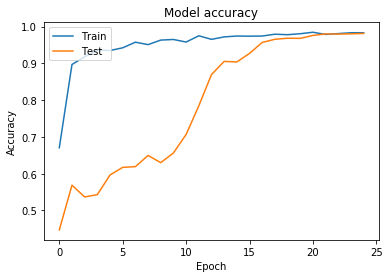

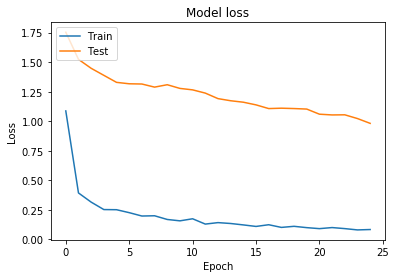

In [23]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Evaluating the model

In [24]:
print("evaluate on training dataset")
model.evaluate(train_data,
              steps=6)

evaluate on training dataset
6/6 [==============================] - 2s 295ms/step - loss: 0.9821 - accuracy: 0.9833


[0.9820990264415741, 0.98333335]

In [25]:
print("evaluate on testing dataset")
model.evaluate(test_data,
               steps=1)

evaluate on testing dataset
1/1 [==============================] - 1s 1s/step - loss: 0.9659 - accuracy: 0.9780


[0.9658542275428772, 0.978]

## Doing prediction with our model

In [ ]:
print("predict on one batch of data")
predict_on_batch = model.predict_on_batch(train_data)
print(model.predict_on_batch(train_data))

predict on one batch of data


In [ ]:
print("test on one batch of data")
print(model.test_on_batch(train_data))

## Confusion Matrix

In [ ]:
# confusion matrix
import tensorflow as tf
rounded_predictions = tf.math.argmax(predict_on_batch,1)
#test_labels = tf.math.argmax(train_data,1)
print(type(train_data))
print(type(predict_on_batch))
#cm = confusion_matrix(test_labels, rounded_predictions)

# I stopped here because debugging this issue might take too much time (for me). 

## Notes
- Increasing the number of epochs to 10 increased the model accuracy which was to be expected but did not hugely increase test accuracy. ==> setup of the network in general not ideal, look for other things to adapt
- increasing the number of epochs to 50 or even 100 greatly improved the model (1)
- Adding 1 or 2 dense layers after the conv layers did not improve the prediction confidence much for few epochs. Model2 with 3 dense layers in classification for 50 or 100 epochs performed worse than model 1. LEss dense layers is more in terms of accuracy for both training and test
- increasing the number of nodes in the dense layer